In [163]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]
sys.path.append('..')
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler #to rescale Euclidean mean
from itertools import chain
from platypus import Solution, Problem
from datetime import datetime
import datetime as DT


import problem_formulation_original, problem_formulation_gini, problem_formulation_euclidean

# Loading solutions (only objectives)

In [164]:
pareto_sets = {}

ethical_formulations = ['TraditionalPrinciple',
                        'CombinedTraditionalGiniMean', 
                        'CombinedTraditionalGiniStd',
                        'CombinedTraditionalGiniRatioStdMean',
                        'CombinedTraditionalEuclideanMean',
                        'CombinedTraditionalEuclideanStd',
                        'CombinedTraditionalEuclideanRatioStdMean',
]

In [165]:
folder_destination = '/Users/farleyrimon/Documents/GitHub/MUSEH2O/susquehanna/output_farley' 
folder_destination_data = '/Users/farleyrimon/Documents/GitHub/MUSEH2O/susquehanna/refsets' 
reference_sets = {}
for entry in ethical_formulations:
    reference_sets[entry] = pd.read_csv(os.path.join(f'{folder_destination_data}', f"{entry}_refset_with_variables_convergence_format.csv"))


# Checking for convergence using Epsilon Progress

Epsilon progress indicates the ability to escape local optima and to find continued improvements to the non-dominated archive. Specifically, the epsilon value indicates the user-specified threshold for which the search algorithm needs to produce at least one solution above this threshold at a certain frequency to avoid stagnation.

We see that the formulations are able to escape their local optima. Nevertheless, we observe two things. First, for the Gini Mean, Euclidean Std, and Euclidean Ratio some of the seeds progress more than others. Hence, the convergence is dependent on the seed being ran. Second, although they escape local optima, none of the formulations seems to have reached a point of convergence. Especially when we compare this to 1 million nfes we can observe that there the epsilon can still progress. While this is true, we see that most formulations have reached some convergence since we do not see a linear growth, which would indicate it has not converged, after approximately 150,000 nfes. The only formulation that does show a more linear behaviour is the Gini Std. Hence, we can trust the solutions given approximate the Pareto front for most formulations, or in other words the solutions have converged, except for the Gini Std formulation.

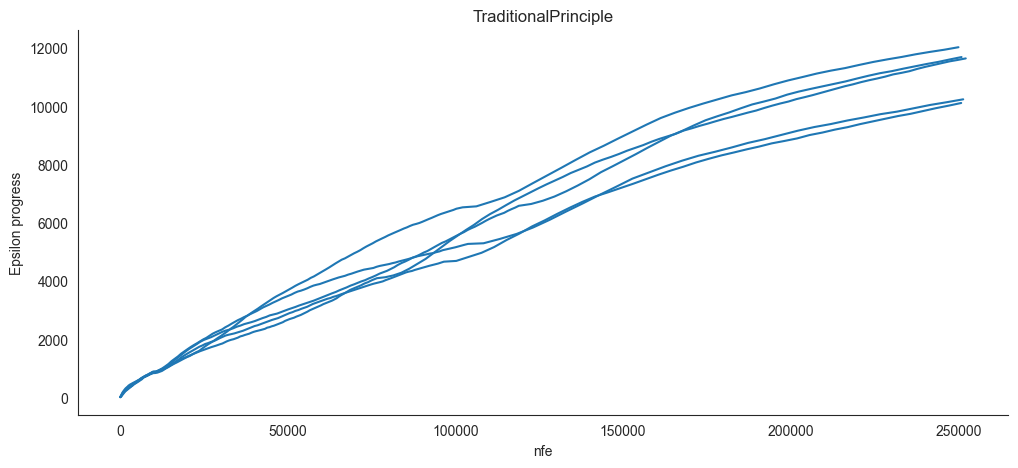

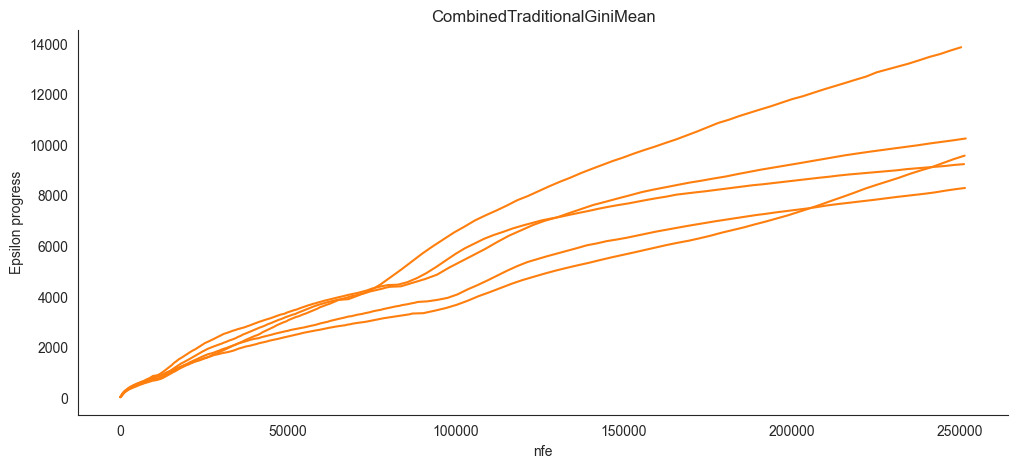

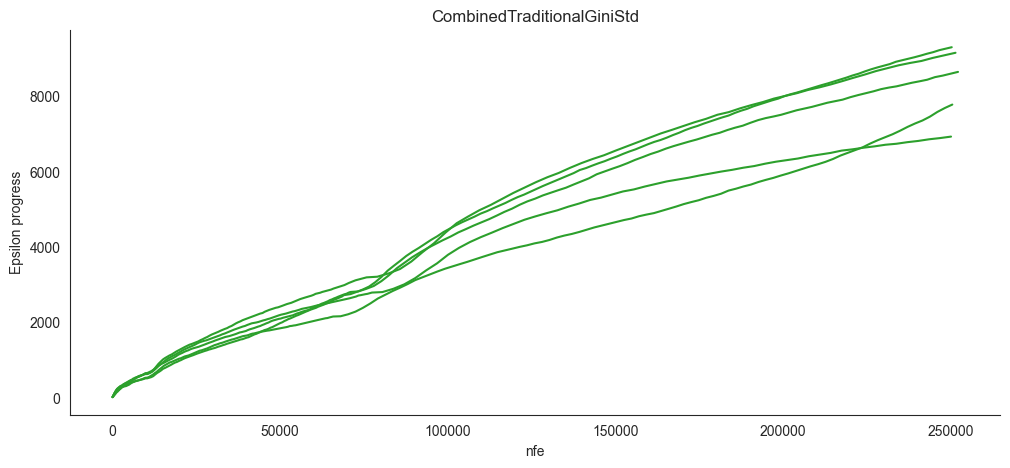

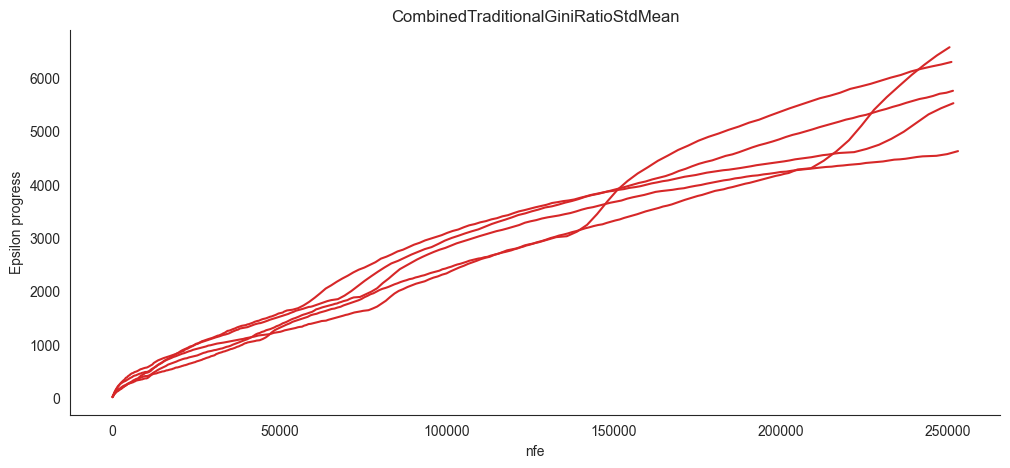

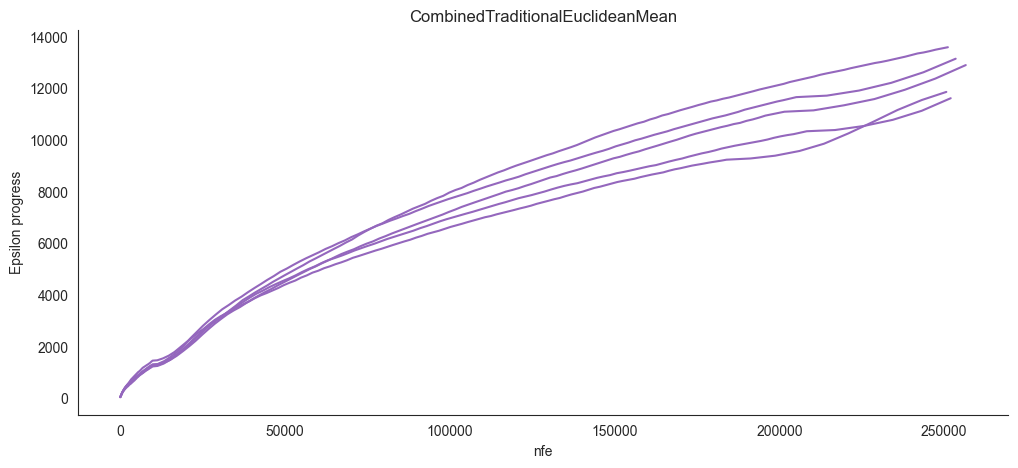

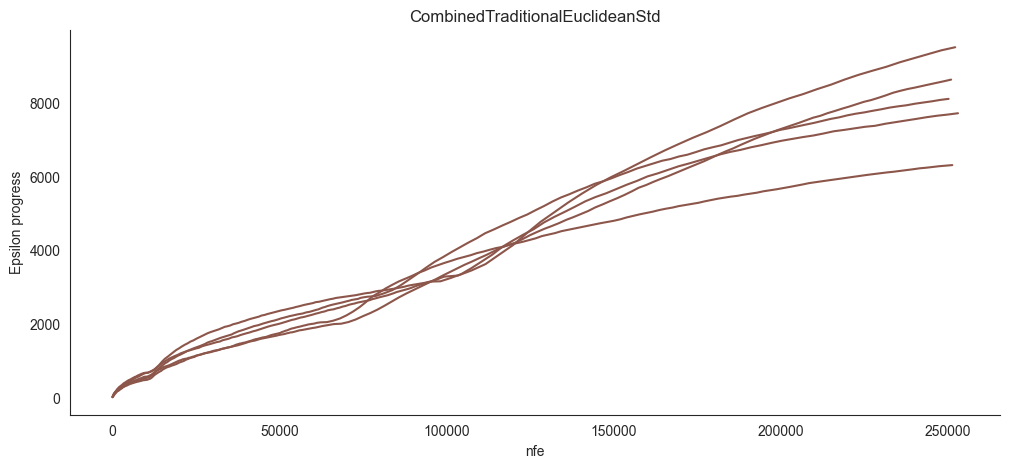

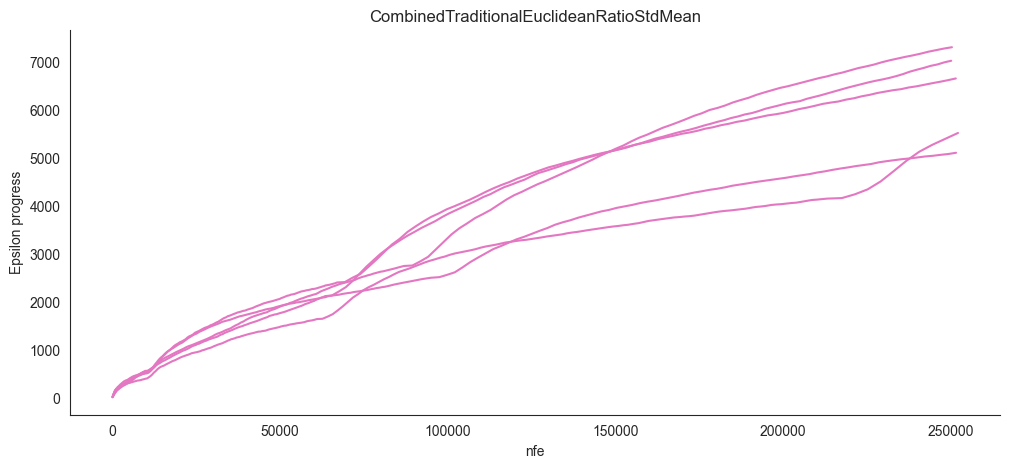

In [181]:
for entry, c in zip(ethical_formulations, sns.color_palette()):
    ep_nfe = {}
    ep_improv = {}
    output_dir = f"/{folder_destination}/{entry}/"
    for i in os.listdir(output_dir):
        if i.endswith("_convergence.csv"):
            ep_load = pd.read_csv(output_dir + i)
            ep_nfe[int(i.split("_")[0])] = ep_load.nfe
            ep_improv[int(i.split("_")[0])]  = ep_load.improvements
    ep_nfe = pd.DataFrame.from_dict(ep_nfe)
    ep_improv = pd.DataFrame.from_dict(ep_improv)
    
    
    fig, ax = plt.subplots(sharex=True)
    ax.plot(ep_nfe, ep_improv, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon progress')
    ax.set_title(entry)
    sns.despine()
    plt.savefig(f'figs/{entry}_epsprog.jpg')
plt.show()

# Generational distance for traditional principle

In [173]:
nfearchive = {}
for n in ethical_formulations[0:1]:
    nfearchive[n] = {}
for entry in ethical_formulations[0:1]:
    name = entry
    output_dir = f"{folder_destination}/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::5]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [174]:
from platypus import Solution, Problem, GenerationalDistance

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation


archives = {}
seeds = np.arange(10, 51, 10).tolist()
for n in ethical_formulations[0:1]:
    archives[n] = {}
    for i in seeds:
        archives[n][i] = {}
for entry in ethical_formulations[0:1]:
    name = entry
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive

In [175]:
# load refsets for each rbf
# ref_dir = "./refsets/"
ref_sets = {}
for n in ethical_formulations[0:1]:
    name = n
    ref_sets[name] = {}
    data = pd.read_csv(f'{folder_destination_data}/{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [176]:
tempnfe = {}
tempgd = {}
nfe_sets = {}
gd_sets = {}
for formulation in archives:
    nfe_sets[formulation] = {}
    gd_sets[formulation] = {}
    gd = GenerationalDistance(reference_set=ref_set) #global refset
    print(f"started {formulation} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[formulation]:
        nfe_sets[formulation][seed] = {}
        gd_sets[formulation][seed] = {}
        s_archives = archives[formulation][seed]
        nfes = []
        gds = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            gds.append(gd.calculate(archive))
        nfe_sets[formulation][seed] = nfes
        gd_sets[formulation][seed] = gds
        tempnfe[seed] = nfes
        tempgd[seed] = gds
        dfgd = pd.DataFrame.from_dict(tempgd, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfgd = dfgd.T
        dfnfe = dfnfe.T
#         dfgd.to_csv(f"gd/gd/{rbf}_gd.csv", index=False)
#         dfnfe.to_csv(f"gd/gd/{rbf}_gd_nfe.csv", index=False)
        dfgd.to_csv(f"gd/gd_global/{formulation}_gd_all.csv", index=False) #global refset
        dfnfe.to_csv(f"gd/gd_global/{formulation}_gd_nfe_all.csv", index=False) #global refset
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started TraditionalPrinciple at 12:55:21
finished seed: 10 at 12:55:32
finished seed: 20 at 12:55:42
finished seed: 30 at 12:55:52
finished seed: 40 at 12:56:03
finished seed: 50 at 12:56:15


### Conclusion

For the traditional principle the generational distance converges around 25,000 nfe. Morerover, it reaches a significantly low value, which is a good sign.

In this case, a low metric value is desired as it indicates the average distance between the global reference set and the Pareto approximation. Generational distance is used in this study mainly to detect absolute failure in our configurations.


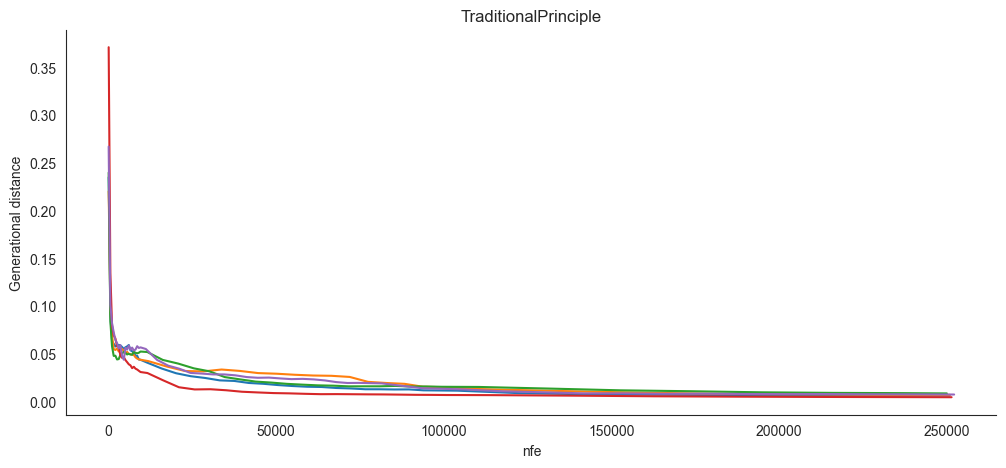

In [141]:
sns.set_style("white")
for entry in ethical_formulations[0:1]:
    name = entry
    gd = pd.DataFrame.from_dict(gd_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, gd)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Generational distance')
    ax.set_title(name)
    sns.despine()

    plt.show()

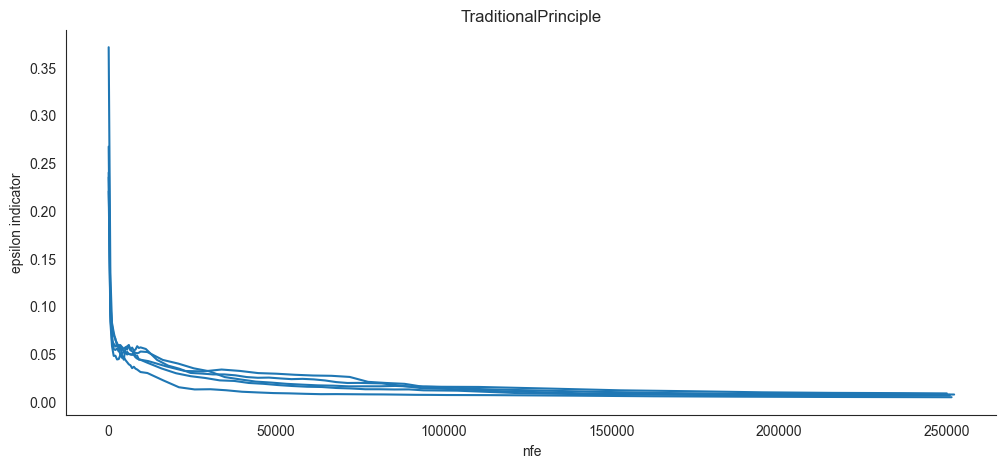

In [145]:
for entry, c in zip(ethical_formulations[0:1], sns.color_palette()):
    formulation = entry
    df_gd = pd.read_csv(f"gd/gd_global/{formulation}_gd_all.csv")
    df_gd_nfe = pd.read_csv(f"gd/gd_global/{formulation}_gd_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_gd_nfe, df_gd, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('epsilon indicator')
    ax.set_title(formulation)
    sns.despine()
    plt.savefig(f'figs/{formulation}_gd.png')
plt.show()

# Epsilon indicator for the traditional principle

In [177]:
from platypus import Solution, Problem, EpsilonIndicator

tempnfe = {}
tempei = {}
nfe_sets = {}
ei_sets = {}
for formulation in archives:
    nfe_sets[formulation] = {}
    ei_sets[formulation] = {}
    ei = EpsilonIndicator(reference_set=ref_set) # global refset
    print(f"started {formulation} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[formulation]:
        nfe_sets[formulation][seed] = {}
        ei_sets[formulation][seed] = {}
        s_archives = archives[formulation][seed]
        nfes = []
        eis = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            eis.append(ei.calculate(archive))
        nfe_sets[formulation][seed] = nfes
        ei_sets[formulation][seed] = eis
        tempnfe[seed] = nfes
        tempei[seed] = eis
        dfei = pd.DataFrame.from_dict(tempei, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfei = dfei.T
        dfnfe = dfnfe.T
        dfei.to_csv(f"epind_global/{formulation}_ei_all.csv", index=False) #global
        dfnfe.to_csv(f"epind_global/{formulation}_ei_nfe_all.csv", index=False) #global
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started TraditionalPrinciple at 12:56:15
finished seed: 10 at 12:56:22
finished seed: 20 at 12:56:29
finished seed: 30 at 12:56:36
finished seed: 40 at 12:56:43
finished seed: 50 at 12:56:51


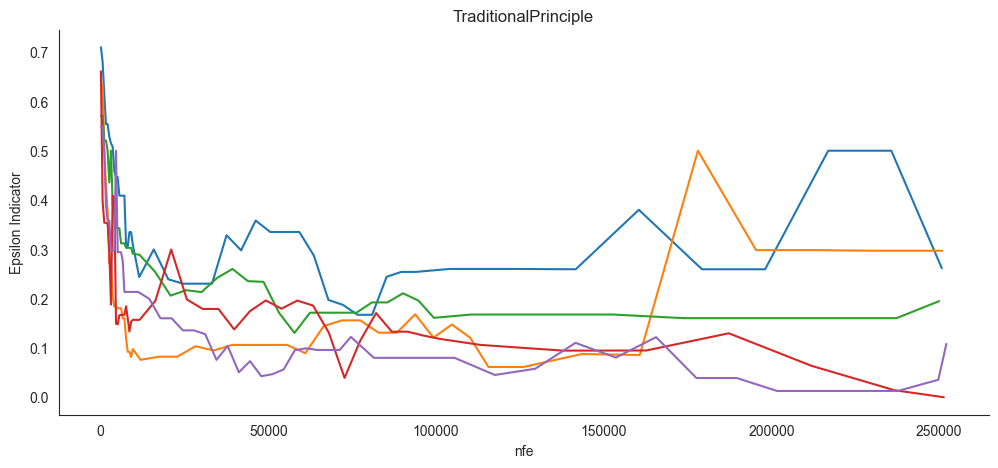

In [180]:
sns.set_style("white")
for entry in ethical_formulations[0:1]:
    name = entry
    ei = pd.DataFrame.from_dict(ei_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, ei)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon Indicator')
    ax.set_title(name)
    sns.despine()
    plt.savefig(f'figs/{entry}_ei.png')

    plt.show()


# Generational distance for distributive justice formulations

In [148]:
nfearchive = {}
for n in ethical_formulations:
    nfearchive[n] = {}
for entry in ethical_formulations[1:]:
    name = entry
    output_dir = f"{folder_destination}/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume_normalized_equity.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::5]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [149]:
from platypus import Solution, Problem, GenerationalDistance

n_rbfs = 4
n_objs = 7
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation
problem.directions[6] = Problem.MINIMIZE  # equity


archives = {}
seeds = np.arange(10, 51, 10).tolist()
for n in ethical_formulations[1:]:
    archives[n] = {}
    for i in seeds:
        archives[n][i] = {}
for entry in ethical_formulations[1:]:
    name = entry
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive

In [150]:
# load refsets for each rbf
ref_dir = "./refsets/"
ref_sets = {}
for n in ethical_formulations[1:]:
    name = n
    ref_sets[name] = {}
    data = pd.read_csv(f'{folder_destination_data}/{name}_refset_convergence_format.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [151]:
tempnfe = {}
tempgd = {}
nfe_sets = {}
gd_sets = {}
for formulation in archives:
    nfe_sets[formulation] = {}
    gd_sets[formulation] = {}
    gd = GenerationalDistance(reference_set=ref_set) #global refset
    print(f"started {formulation} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[formulation]:
        nfe_sets[formulation][seed] = {}
        gd_sets[formulation][seed] = {}
        s_archives = archives[formulation][seed]
        nfes = []
        gds = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            gds.append(gd.calculate(archive))
        nfe_sets[formulation][seed] = nfes
        gd_sets[formulation][seed] = gds
        tempnfe[seed] = nfes
        tempgd[seed] = gds
        dfgd = pd.DataFrame.from_dict(tempgd, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfgd = dfgd.T
        dfnfe = dfnfe.T
#         dfgd.to_csv(f"gd/gd/{rbf}_gd.csv", index=False)
#         dfnfe.to_csv(f"gd/gd/{rbf}_gd_nfe.csv", index=False)
        dfgd.to_csv(f"gd/gd_global/{formulation}_gd_all.csv", index=False) #global refset
        dfnfe.to_csv(f"gd/gd_global/{formulation}_gd_nfe_all.csv", index=False) #global refset
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started CombinedTraditionalGiniMean at 12:00:27
finished seed: 10 at 12:00:45
finished seed: 20 at 12:01:05
finished seed: 30 at 12:01:22
finished seed: 40 at 12:01:42
finished seed: 50 at 12:02:05
started CombinedTraditionalGiniStd at 12:02:05
finished seed: 10 at 12:02:31
finished seed: 20 at 12:02:52
finished seed: 30 at 12:03:14
finished seed: 40 at 12:03:34
finished seed: 50 at 12:03:53
started CombinedTraditionalGiniRatioStdMean at 12:03:53
finished seed: 10 at 12:04:10
finished seed: 20 at 12:04:27
finished seed: 30 at 12:04:45
finished seed: 40 at 12:05:01
finished seed: 50 at 12:05:20
started CombinedTraditionalEuclideanMean at 12:05:20
finished seed: 10 at 12:06:04
finished seed: 20 at 12:06:39
finished seed: 30 at 12:07:09
finished seed: 40 at 12:07:36
finished seed: 50 at 12:08:07
started CombinedTraditionalEuclideanStd at 12:08:07
finished seed: 10 at 12:08:28
finished seed: 20 at 12:08:50
finished seed: 30 at 12:09:11
finished seed: 40 at 12:09:32
finished seed: 50 at 12:

### Conclusion

In this case, a low metric value is desired as it indicates the average distance between the global reference set and the Pareto approximation. Generational distance is used in this study mainly to detect absolute failure in our configurations.


We see that around 50, 000 nfes most solutions have converged. We conclude this from the fact that the generational distance converges at a reasonably low value from the global reference set, which aims to represent the real Pareto front.

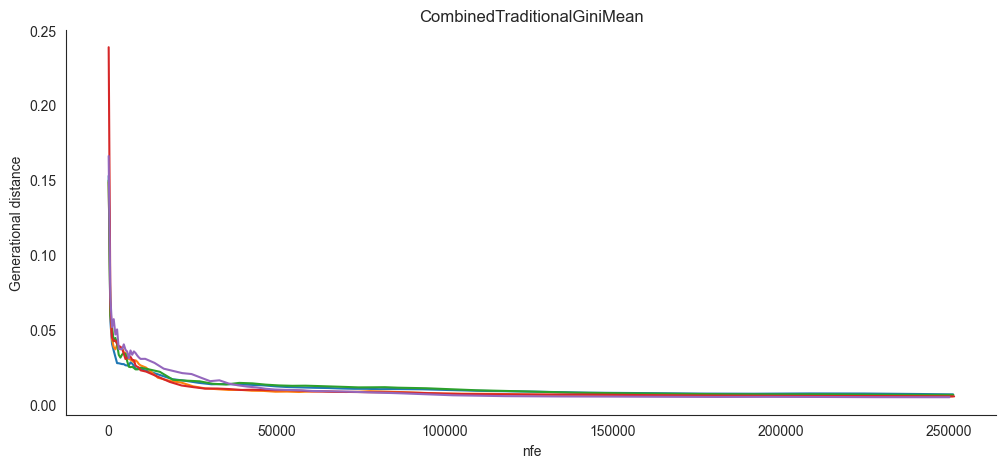

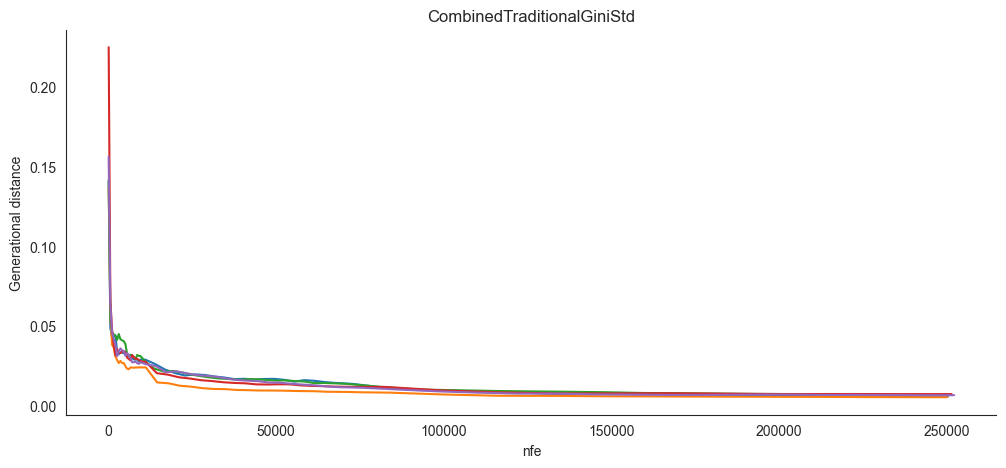

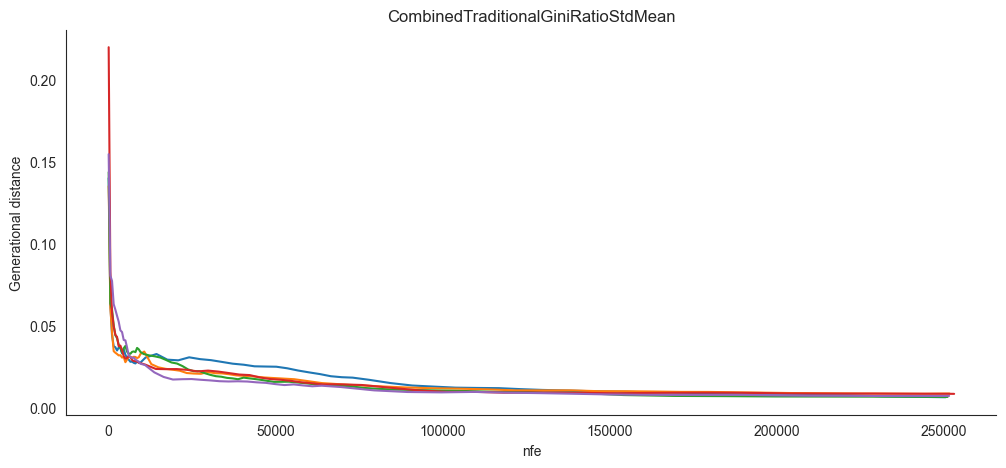

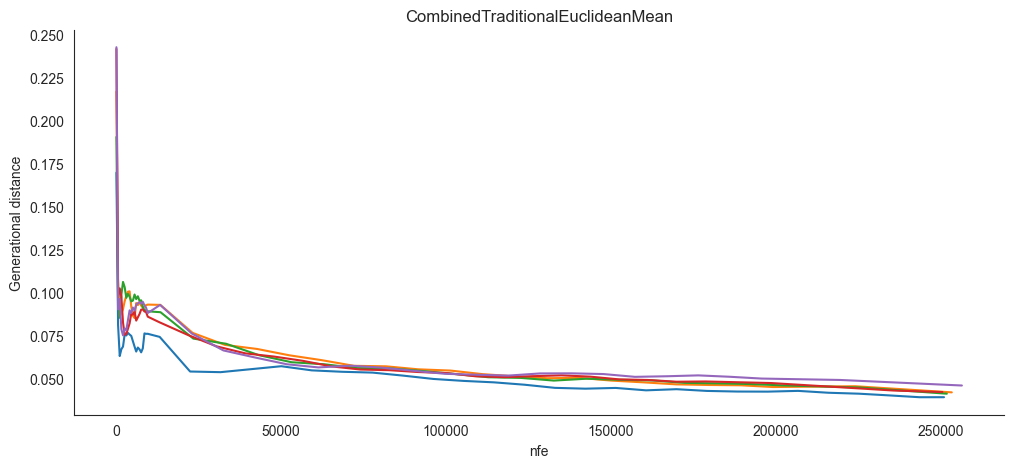

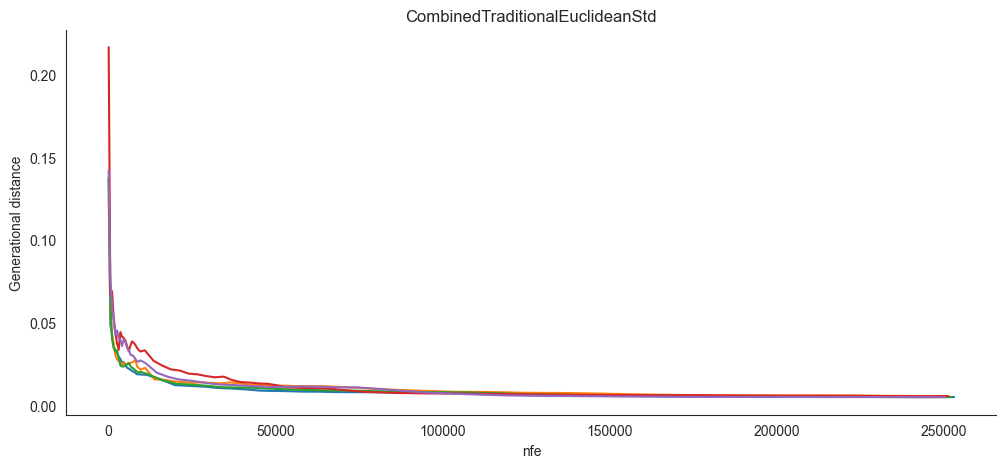

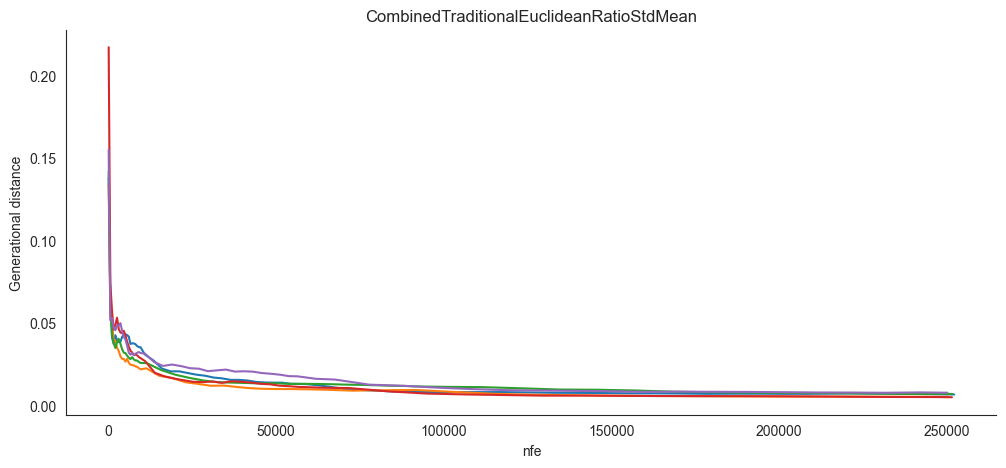

In [152]:
sns.set_style("white")
for entry in ethical_formulations[1:]:
    name = entry
    gd = pd.DataFrame.from_dict(gd_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, gd)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Generational distance')
    ax.set_title(name)
    sns.despine()

    plt.show()

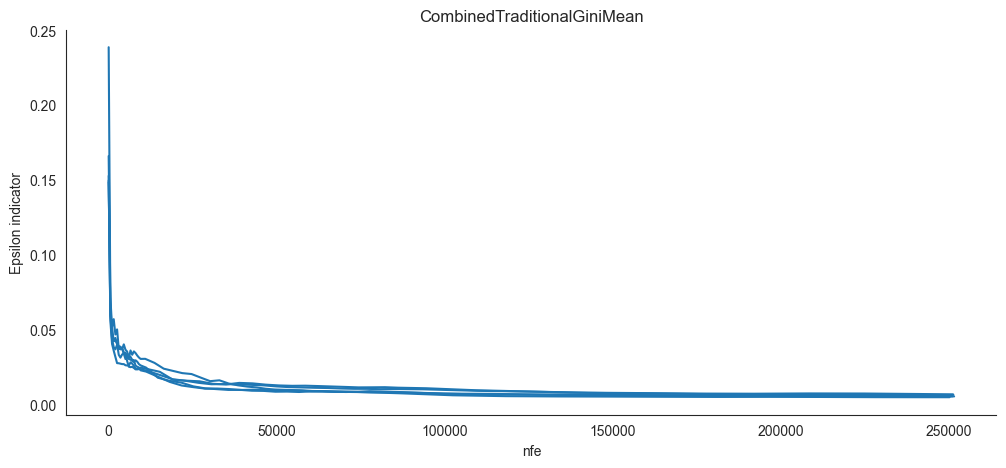

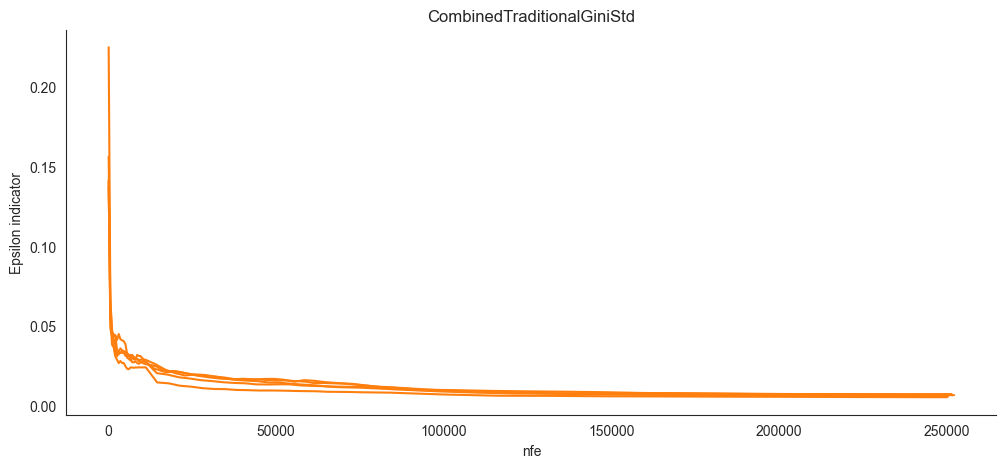

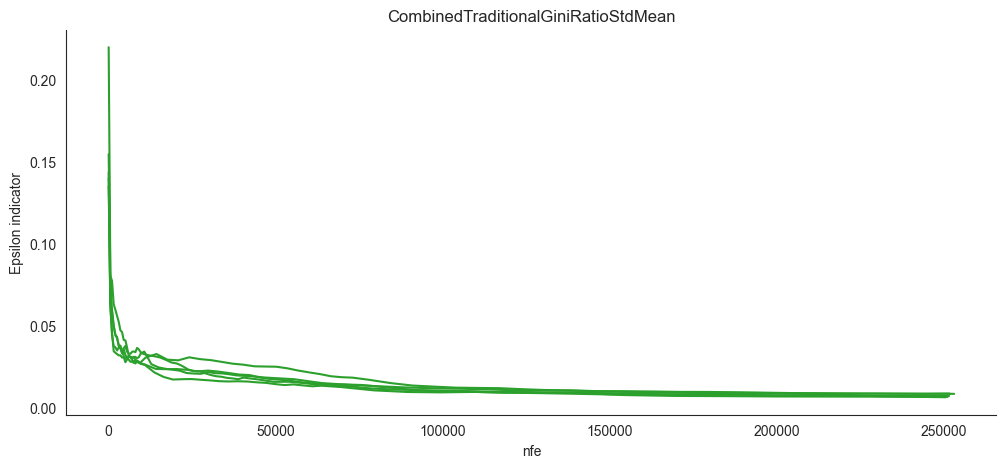

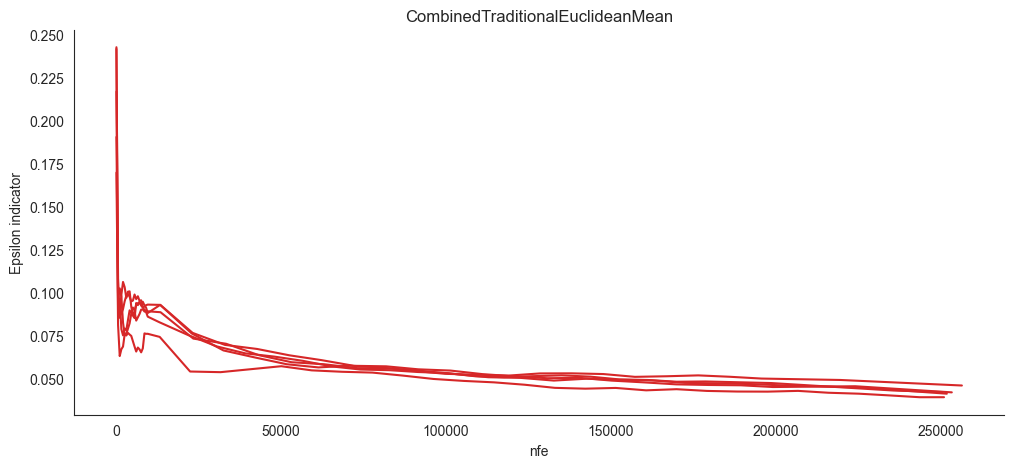

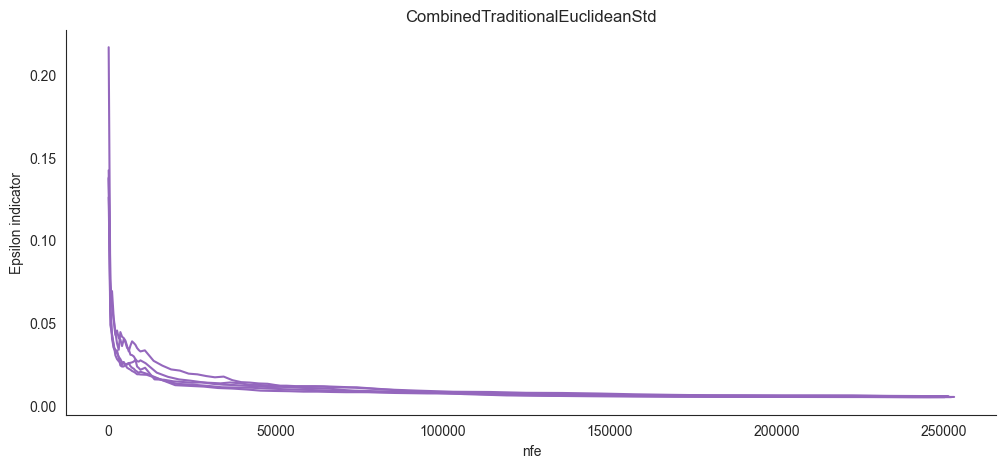

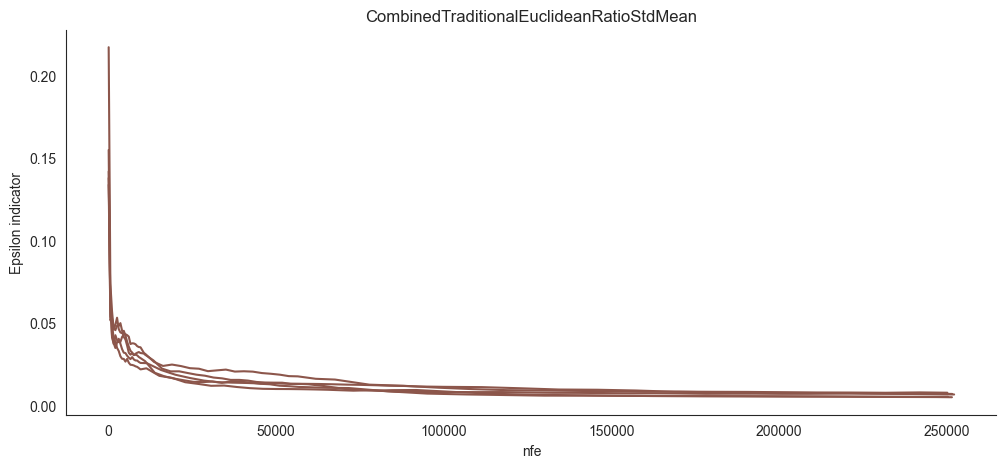

In [153]:
for entry, c in zip(ethical_formulations[1:], sns.color_palette()):
    formulation = entry
    df_gd = pd.read_csv(f"gd/gd_global/{formulation}_gd_all.csv")
    df_gd_nfe = pd.read_csv(f"gd/gd_global/{formulation}_gd_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_gd_nfe, df_gd, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon indicator')
    ax.set_title(formulation)
    sns.despine()
    plt.savefig(f'figs/{formulation}_gd.png')
plt.show()

# Epsilon indicator for distributive justice formulations

In [154]:
from platypus import Solution, Problem, EpsilonIndicator

tempnfe = {}
tempei = {}
nfe_sets = {}
ei_sets = {}
for formulation in archives:
    nfe_sets[formulation] = {}
    ei_sets[formulation] = {}
#     ei = EpsilonIndicator(reference_set=ref_sets[rbf])
    ei = EpsilonIndicator(reference_set=ref_set) # global refset
    print(f"started {formulation} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[formulation]:
        nfe_sets[formulation][seed] = {}
        ei_sets[formulation][seed] = {}
        s_archives = archives[formulation][seed]
        nfes = []
        eis = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            eis.append(ei.calculate(archive))
        nfe_sets[formulation][seed] = nfes
        ei_sets[formulation][seed] = eis
        tempnfe[seed] = nfes
        tempei[seed] = eis
        dfei = pd.DataFrame.from_dict(tempei, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfei = dfei.T
        dfnfe = dfnfe.T
        dfei.to_csv(f"epind_global/{formulation}_ei_all.csv", index=False) #global
        dfnfe.to_csv(f"epind_global/{formulation}_ei_nfe_all.csv", index=False) #global
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started CombinedTraditionalGiniMean at 12:11:39
finished seed: 10 at 12:11:51
finished seed: 20 at 12:12:04
finished seed: 30 at 12:12:15
finished seed: 40 at 12:12:28
finished seed: 50 at 12:12:43
started CombinedTraditionalGiniStd at 12:12:43
finished seed: 10 at 12:13:00
finished seed: 20 at 12:13:14
finished seed: 30 at 12:13:28
finished seed: 40 at 12:13:41
finished seed: 50 at 12:13:54
started CombinedTraditionalGiniRatioStdMean at 12:13:54
finished seed: 10 at 12:14:04
finished seed: 20 at 12:14:15
finished seed: 30 at 12:14:27
finished seed: 40 at 12:14:37
finished seed: 50 at 12:14:50
started CombinedTraditionalEuclideanMean at 12:14:50
finished seed: 10 at 12:15:19
finished seed: 20 at 12:15:42
finished seed: 30 at 12:16:02
finished seed: 40 at 12:16:20
finished seed: 50 at 12:16:41
started CombinedTraditionalEuclideanStd at 12:16:41
finished seed: 10 at 12:16:55
finished seed: 20 at 12:17:10
finished seed: 30 at 12:17:24
finished seed: 40 at 12:17:37
finished seed: 50 at 12:

### Conclusion

The additive epsilon indicator measures gaps in the Pareto front, hence, it is a harder metric to meet than generational distance. Similarly to generational distance, this metric is computed relative to a global reference set and a low value is desired as it measures the distance that an approximation set needs to be translated in order to dominate the global reference set.

We note that the Gini Mean principle does not approach low distances, as well as the Euclidean Mean. Conversely, it is these two formulations that show least variability in solutions found across seeds. As a matter of fact, the Mean formulations are far off from an ideal distance. An explanation for this could be that the global reference set is calculated without having a methodology that standardizes the distributive justice values from each formulation to a uniform value. Therefore, formulations such as the Euclidean Mean with values that are significantly above 1, have a different range to Gini values between 0 and 1. Therefore, the global reference set will not fully represent the real Pareto front since one of the seven objectives has different ranges across formulations. Other formulations (the traditional objectives) will lie within the expected range, and thus approximate the real Pareto front.

Other formulations converge towards a low distance from the global reference set. However, we see a significant amount of variability for the Gini Ratio, Gini Standard Deviation, and Euclidean Standard Deviation, while for the Euclidean Ratio the solution is more stable.

Hence, for most of the formulations, the epsilon indicator that there is quite some variability across seeds for each formulation. This may indicate that the Pareto front captured does not only represent one trade-off, but rather several combinations of the trade-off, without actually being near to the global reference (except for the Euclidean Ratio, Euclidean Std, and Gini Std).

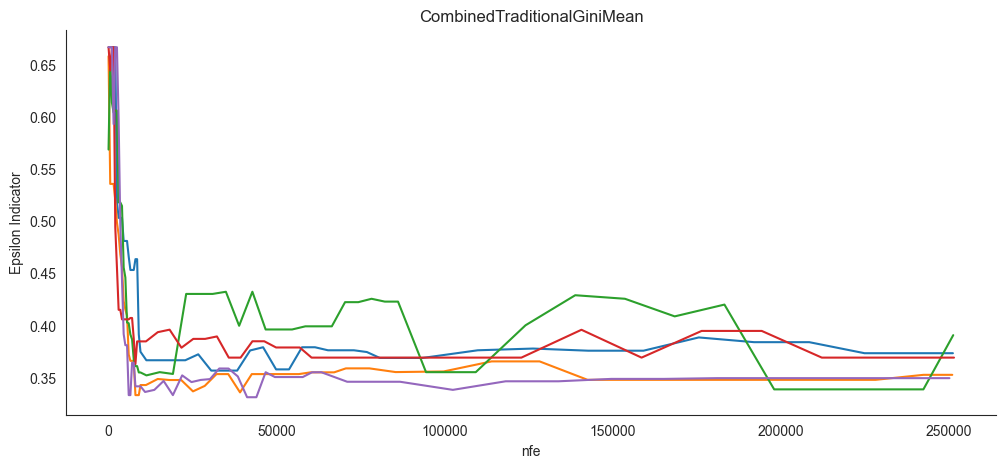

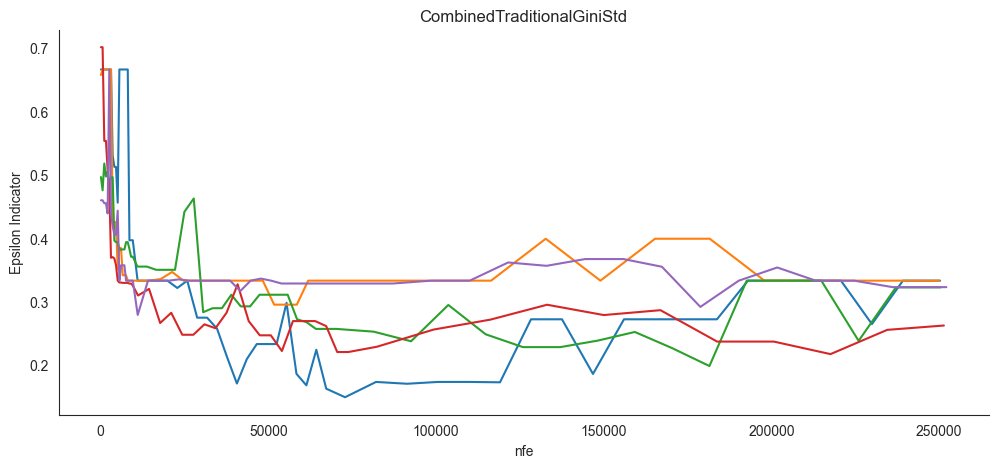

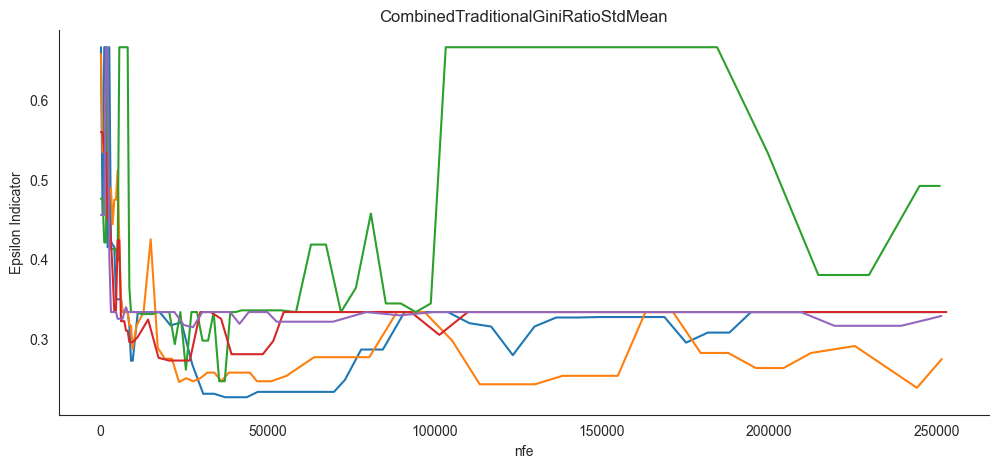

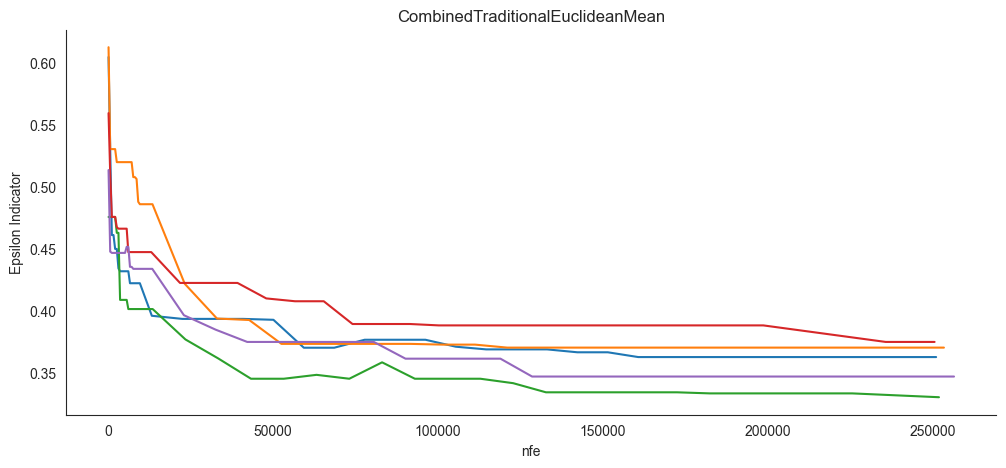

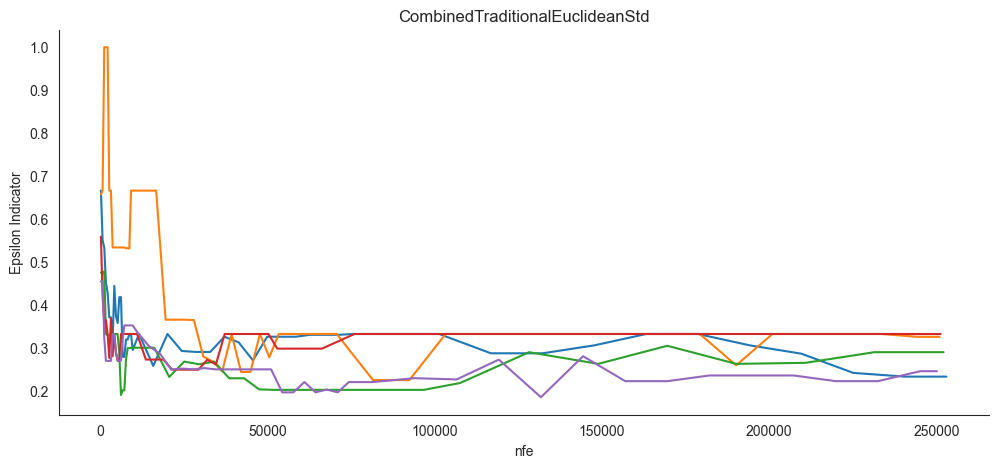

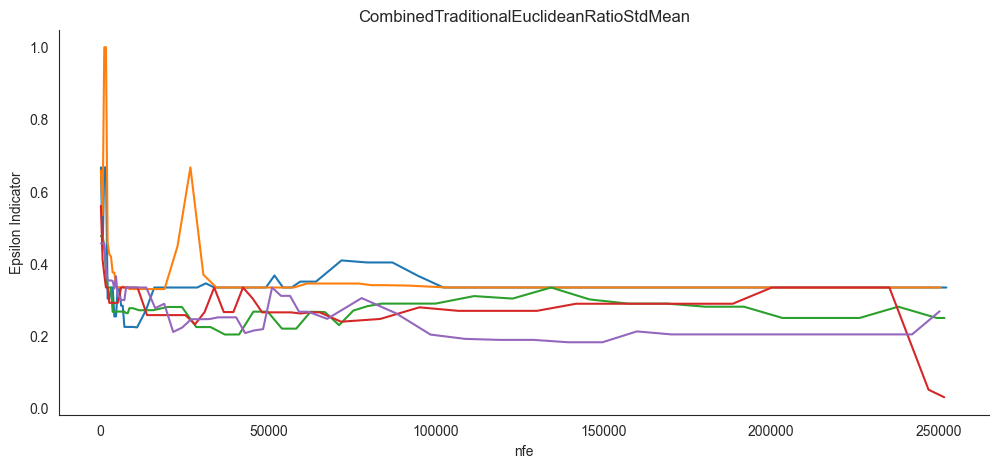

In [155]:
sns.set_style("white")
for entry in ethical_formulations[1:]:
    name = entry
    ei = pd.DataFrame.from_dict(ei_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, ei)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon Indicator')
    ax.set_title(name)
    sns.despine()

    plt.show()

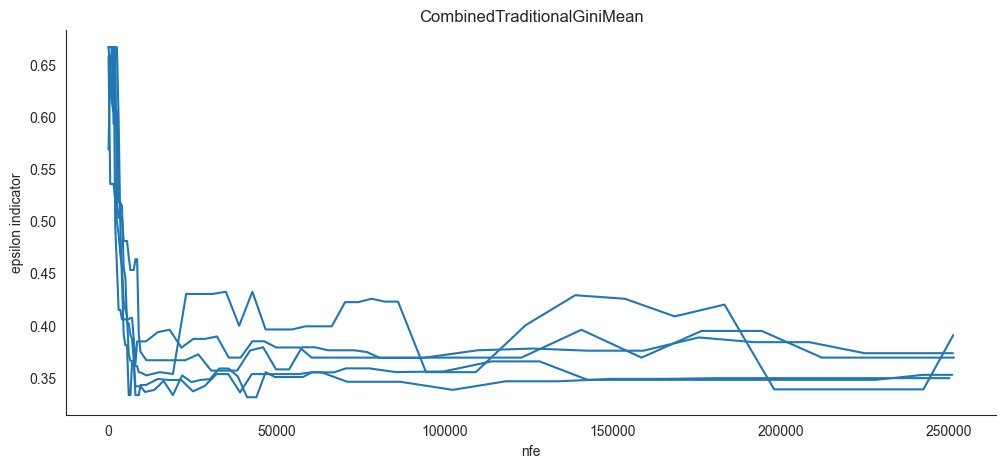

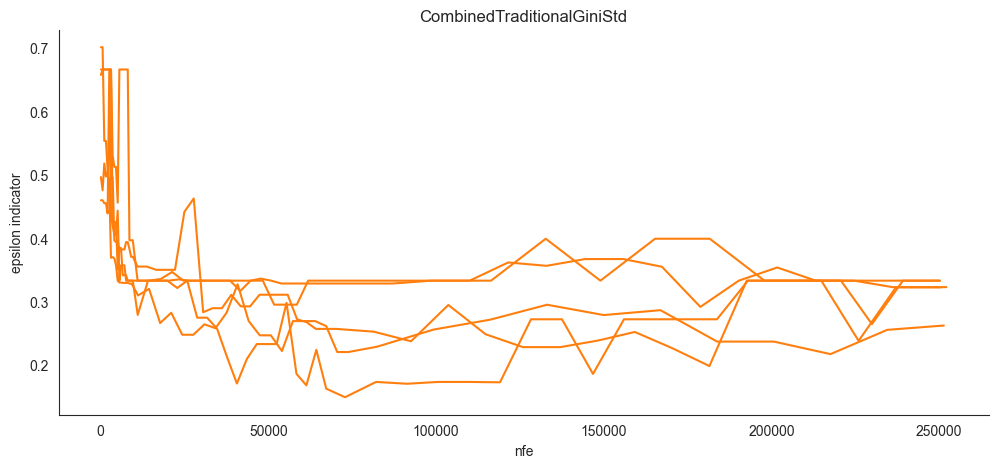

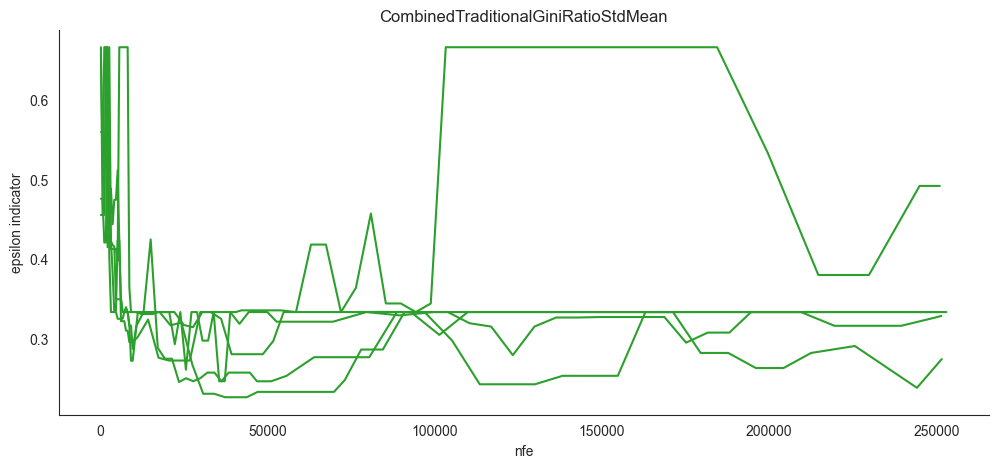

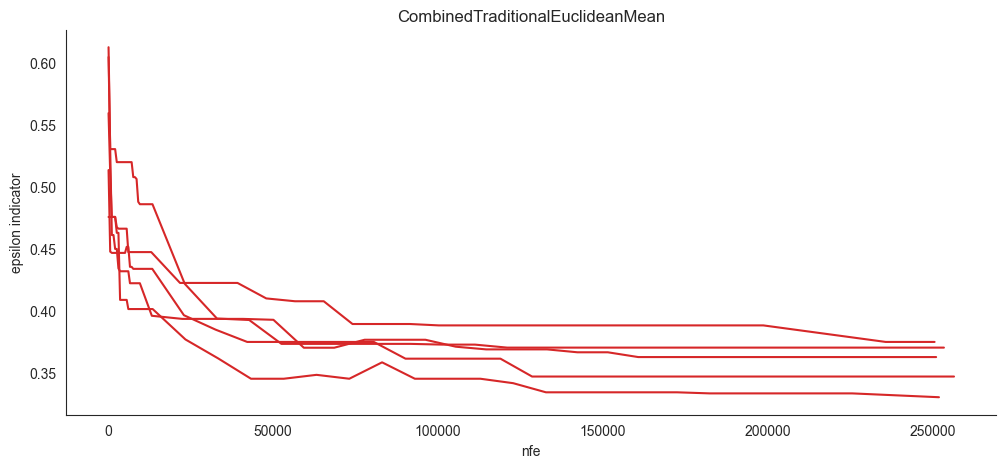

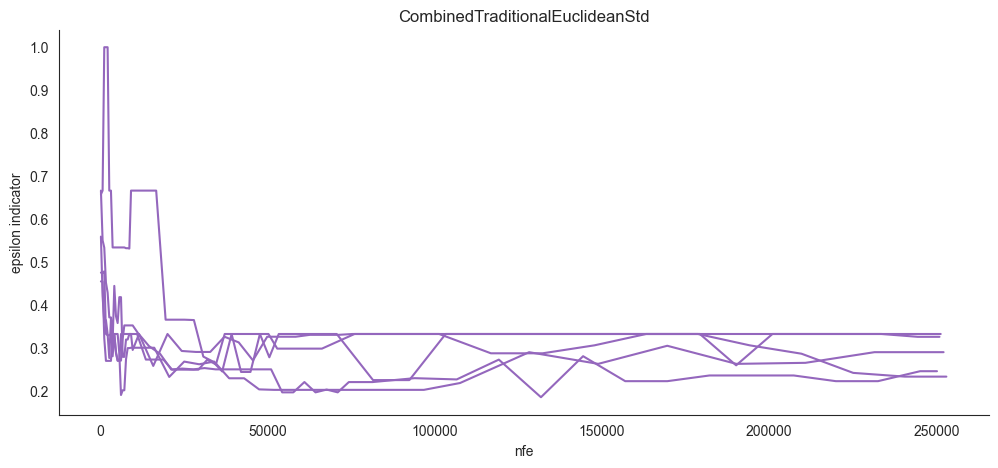

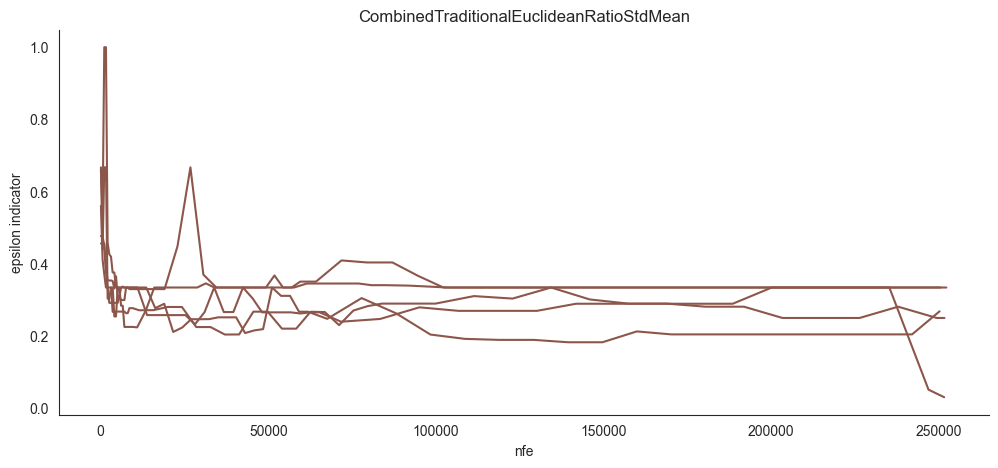

In [156]:
for entry, c in zip(ethical_formulations[1:], sns.color_palette()):
    formulations = entry
    df_ei = pd.read_csv(f"epind_global/{formulations}_ei_all.csv")
    df_ei_nfe = pd.read_csv(f"epind_global/{formulations}_ei_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_ei_nfe, df_ei, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('epsilon indicator')
    ax.set_title(formulations)
    sns.despine()
    plt.savefig(f'figs/{formulations}_ei.png')
plt.show()

# Hypervolume will take too long to run, so we do not do it.

# Checking for convergence using Hypervolume (method 1)

In [110]:
import sys
import rbf_functions
import os
sys.path.append(os.path.abspath("../.."))
from hypervolume_jk import HypervolumeMetric
from hv_calculation import get_platypus_problem
from hv_calculation import transform_data

In [113]:
refset = pd.read_csv(f"{folder_destination_data}/refsets/{ethical_formulations[1]}_refset.csv", header = 0)
# refset = refset.drop('equity',axis=1)

problem = get_platypus_problem(7, ethical_formulations[1])

In [114]:
# refset = refset.drop("equity")
# refset = refset.reset_index()
# refset = refset.drop('equity')

In [115]:
hv = HypervolumeMetric(refset, problem)

In [116]:
data = pd.read_csv(f"{folder_destination}/{ethical_formulations[1]}/10_hypervolume.csv")
generations = []
for nfe, generation in data.groupby("Unnamed: 0"):
    generation = generation.rename(
        {
            str(i): name
            for i, name in enumerate(
            [
                "hydropower",
                "atomicpowerplant",
                "baltimore",
                "chester",
                "environment",
                "recreation",
                "equity"
            ]
        )
        },
        axis=1,
    )
    generations.append(generation.iloc[:, 2::])

In [118]:
# let's pick one and see what happens
g = generations[10]
# %%timeit
hv.calculate(g)

0.14638950165195017

In [119]:
from deap.tools import _hypervolume
from sklearn.preprocessing import MinMaxScaler
problem = get_platypus_problem(7, 'CombinedTraditionalGiniMean' )

directions = np.asarray([entry for entry in problem.directions])
directions

array([ 1,  1,  1,  1, -1,  1, -1])

In [120]:
df_testt = pd.DataFrame(refset.values)

,0,1,2,3,4,5,6
0,57.419404,0.605698,0.053619,0.372416,-0.084460,1.0,-0.201638
1,41.520980,0.669718,0.152515,0.227765,-0.081774,1.0,-0.202931
2,58.074703,0.335548,0.423978,0.113162,-0.087124,1.0,-0.201085
3,39.465134,0.654118,0.068586,0.251685,-0.081216,1.0,-0.217180
4,59.433866,0.110872,0.216295,0.578788,-0.085445,1.0,-0.207893
...,...,...,...,...,...,...,...
156,68.612850,0.984024,0.689883,0.919287,-0.097215,1.0,-0.100568
157,30.120199,0.667551,0.566201,0.037869,-0.085063,1.0,-0.207249
158,75.846303,0.504920,0.126302,0.221936,-0.088090,1.0,-0.210472
159,70.611295,0.467622,0.305582,0.103257,-0.084846,1.0,-0.207064


In [121]:
def handle_directions(data, problem):
    data = data.copy()
    for i in range(data.shape[1]):
        column = data[:, i]
        if problem.directions[i] == problem.MAXIMIZE:
            data[:, i] = 1 - column
    return data

ref_set = refset.values
generation = g.values

# normalize using the min and max across all generations and reference set
# this is slightly different from how platypus handles it
scaler = MinMaxScaler()
# scaler.fit(pd.concat(generations + [refset]).values)
scaler.fit(ref_set)

normalized_refset = scaler.transform(ref_set)
normalized_generation = scaler.transform(generation)

refset_directed = handle_directions(normalized_refset, problem) 
generation_directed = handle_directions(normalized_generation, problem)


maxima = np.max(refset_directed, axis=0)
minima = np.min(refset_directed, axis=0)

print(minima)
print(maxima)
print(_hypervolume.hv.hypervolume(generation_directed, maxima))
print(_hypervolume.hv.hypervolume(normalized_generation, maxima))

[0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1.]
0.14667204799868638
25.605781108404035


In [122]:
from hv_calculation import load_archives

archives, list_of_archives = load_archives(folder_destination)

In [123]:
problem = get_platypus_problem(7, ethical_formulations[1])
scaler = MinMaxScaler()
scaler.fit(pd.concat(list_of_archives + [refset]).values)
reference_set = transform_data(refset.values, scaler, problem)
maxima = np.max(reference_set, axis=0)

In [ ]:
hv = _hypervolume.hv.hypervolume(reference_set, maxima)
dict(hv=hv)

In [125]:
pd.Series(dict(hv=hv)).to_csv('./calculated_metrics/hv_refset_global.csv')

In [126]:
problem = get_platypus_problem(7, ethical_formulations[1])

scaler = MinMaxScaler()
scaler.fit(pd.concat(generations + [refset]).values)


refset_directed = transform_data(refset.values, scaler, problem)
maxima = np.max(refset_directed, axis=0)


hypervolume = []
for generation in generations[0:200]:
    generation_directed = transform_data(generation.values, scaler, problem)
    hv = _hypervolume.hv.hypervolume(generation_directed, maxima)
    hypervolume.append(hv)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(hypervolume)

# Checking for convergence using Hypervolume (method 2)

In [80]:
# output_dir = f"../output/{rbf}/"
nfearchive = {}
for n in ethical_formulations:
    nfearchive[n] = {}
for entry in ethical_formulations[1:]:
    name = entry
    output_dir = f"{folder_destination}/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
#             nfearchive[name][i.split("_")[0]] = pd.read_csv(output_dir + i)
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
#             selected_nfe = u_nfes[-1::]
            selected_nfe = u_nfes[0::10]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [81]:
from platypus import Solution, Problem, Hypervolume

n_rbfs = 4
n_objs = 7
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation
problem.directions[6] = Problem.MINIMIZE  # equity


archives = {}
seeds = np.arange(10, 51, 10).tolist()
print(seeds)
for n in ethical_formulations[1:]:
    archives[n] = {}
    for i in seeds:
        archives[n][i] = {}
for entry in ethical_formulations[1:]:
    name = entry
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
#                 print(problem)
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive

[10, 20, 30, 40, 50]


In [82]:
# folder_destination_refsets = f'/Users/farleyrimon/Documents/Model_results/Experiment 2/refsets'
ref_sets = {}
for n in ethical_formulations[1:]:
    name = n
    ref_sets[name] = {}
    data = pd.read_csv(f'{folder_destination_data}/{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
#         print(problem)
        solution = Solution(problem)
#         print(solution)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set


FileNotFoundError: [Errno 2] No such file or directory: '/Users/farleyrimon/Documents/GitHub/MUSEH2O/susquehanna/CombinedTraditionalGiniMean_refset.csv'

In [ ]:
ref_sets.keys()


In [ ]:
from datetime import datetime
import datetime as DT

In [ ]:
ethical_formulation = ethical_formulations[1]
tempnfe = {}
temphv = {}
nfe_sets = {}
hv_sets = {}
# for rbf in archives:
nfe_sets[ethical_formulation] = {}
hv_sets[ethical_formulation] = {}
hv = Hypervolume(reference_set=ref_sets[ethical_formulation])
# hv = Hypervolume(reference_set=ref_set) #global
print(f"started {ethical_formulation} at {DT.datetime.now().strftime('%H:%M:%S')}")
# seedl = [10, 20, 30]
for seed in archives[ethical_formulation]:
    nfe_sets[ethical_formulation][seed] = {}
    hv_sets[ethical_formulation][seed] = {}
    s_archives = archives[ethical_formulation][seed]
    nfes = []
    hvs = []
    for nfe, archive in s_archives.items():
        nfes.append(nfe)
        hvs.append(hv.calculate(archive))
    nfe_sets[ethical_formulation][seed] = nfes
    hv_sets[ethical_formulation][seed] = hvs
    tempnfe[seed] = nfes
    temphv[seed] = hvs
    dfhv = pd.DataFrame.from_dict(temphv, orient='index')
    dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
    dfhv = dfhv.T
    dfnfe = dfnfe.T
    dfhv.to_csv(f"hv/{ethical_formulation}_hv.csv", index=False)
    dfnfe.to_csv(f"hv/{ethical_formulation}_nfe.csv", index=False)
#     dfhv.to_csv(f"hv_global/{rbf}_hv_all.csv", index=False) #global
#     dfnfe.to_csv(f"hv_global/{rbf}_nfe_all.csv", index=False) #global
    print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

In [ ]:
rbf = 'original_rbf'

fig, ax = plt.subplots(sharex=True)
for i in nfe_sets_all:
    ax.plot(nfe_sets_all[i], hv_sets_all[i])

ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax.set_title(ethical_formulations[1])
sns.despine()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

# Plot hypervolume for each rbf

for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_hv = pd.read_csv(f"hv/{rbf}_hv.csv")
    df_hv_nfe = pd.read_csv(f"hv/{rbf}_hv_nfe.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_hv_nfe, df_hv, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('hypervolume')
    ax.set_title(ethical_formulations[1])
    sns.despine()
#     plt.savefig(f'figs/{rbf}/{rbf}_hv.jpg')
plt.show()